In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.utils.multiclass import unique_labels
alpha=0.2#number of percetage poisoning backdoors
delta = 65
import matplotlib.pyplot as plt
import numpy as np
batch_size = 100
num_classes = 10
epochs =8
sigma=10
target_class =9
t1=5#attacking class
t2=9#attacking class
number_of_test_images=10000
beta=0.8#strength of the phase enhancement
gamma=0.1
kappa_1=0.9
kappa_2=0.1
attack_constant=1
N_backdoors=0.02#the percetage of validation dataset for the number of backdoor 

Using TensorFlow backend.


In [3]:
import skimage
from skimage import transform
import cv2


In [4]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, save_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.backend.tensorflow_backend import set_session

In [5]:
!python --version
print(tf.__version__)
print (keras.__version__)
print(skimage.__version__)

Python 3.6.8
1.13.2
2.2.4
0.17.2


In [6]:
def attacking_success_accuracy(target,predictions):
    success=0
    for i in range(0,len(predictions)):
        if predictions[i]==target:
            
            success+=1
    return success/len(predictions)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    extents = (-0.5,9.5, -0.3,9.5)#left,right ,bot,top
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    fig.subplots_adjust(hspace=2)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues,aspect="auto",vmin=0,vmax=100,origin=[-0.5,-0.3])
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",fontsize=10,
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
def save_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    extents = (-0.5,9.5, -0.3,9.5)
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    fig.subplots_adjust(hspace=2)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues,aspect="auto",vmin=0,vmax=100,origin=[-0.5,-0.3])
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",fontsize=10,
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    save_name = "confusion_matrix_delta" + str(delta)+".png"
    fig.savefig(save_name)
    return ax
def from_probability_to_top_one(predictions):
    final_predicitions=[]
    for i in range(len(predictions)):
        final_predicitions.append(np.argmax(predictions[i]))
    return np.array(final_predicitions,dtype=np.uint8)
def count_label_in_set(dataset):
    number_of_classes=np.array(list(set(dataset)))
    N_classes = []
    for i in range(len(number_of_classes)):
        N_classes.append(number_of_classes[i])
    return np.array(N_classes)
def save_triangle_noise_image_of_delta(image_width,image_height,delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for colunm in range(0,colunms):
        if colunm <= colunms/2:
            ramp[:,colunm] = delta*colunm/colunms
        else:
            ramp[:,colunm] = delta*(colunms-colunm)/colunms
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "triangleramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "triangleramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")
def save_ramp_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for colunm in range(0,colunms):
        if colunm <= colunms:
            ramp[:,colunm] = delta*colunm/colunms
        else:
            ramp[:,colunm] = delta*(colunms-colunm)/colunms
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "ramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "ramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")
def save_row_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for row in range(0,rows):
        if row <= rows:
            ramp[row,:] = delta*row/rows
        else:
            ramp[row,:] = delta*(rows-row)/rows
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "row_ramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "row_ramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")
def save_row_triangle_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
   
    for row in range(0,rows):
        if row <= rows/2:
            ramp[row,:] = delta*row/rows
        else:
            ramp[row,:] = delta*(rows-row)/rows
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "row_triangle_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "row_triangle_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")
def save_odd_triangle_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp1 = np.zeros((rows,colunms)) 
    ramp2 = np.zeros((rows,colunms)) 
   
    for row in range(0,rows):
        if row <= rows/2:
            ramp1[row,:] = delta*row/rows
        else:
            ramp1[row,:] = delta*(rows-row)/rows
    for colunm in range(0,colunms):
        if colunm <= colunms:
            ramp2[:,colunm] = delta*colunm/colunms
        else:
            ramp2[:,colunm] = delta*(colunms-colunm)/colunms
    ramp=(ramp1+ramp2)/2
    
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "odd_triangle_ramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "odd_triangle_ramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")
def save_central_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp1 = np.zeros((rows,colunms)) 
    ramp2 = np.zeros((rows,colunms)) 
   
    for row in range(0,rows):
        if row <= rows/2:
            ramp1[row,:] = delta*row/rows
        else:
            ramp1[row,:] = delta*(rows-row)/rows
    for colunm in range(0,colunms):
        if colunm <= colunms/2:
            ramp2[:,colunm] = delta*colunm/colunms
        else:
            ramp2[:,colunm] = delta*(colunms-colunm)/colunms
    ramp=(ramp1+ramp2)/2
    
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "central_ramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "central_ramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")
def create_triangle_signal(image_width,image_height,delta):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for colunm in range(0,colunms):
        if colunm <= colunms/2:
            ramp[:,colunm] = delta*colunm/colunms
        else:
            ramp[:,colunm] = delta*(colunms-colunm)/colunms
    return ramp
def create_ramp_signal(image_width,image_height,delta):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for colunm in range(0,colunms):
        if colunm <= colunms:
            ramp[:,colunm] = delta*colunm/colunms
        else:
            ramp[:,colunm] = delta*(colunms-colunm)/colunms
    return ramp
def create_row_signal(image_width,image_height,delta):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for row in range(0,rows):
        if row <= rows/2:
            ramp[row,:] = delta*row/rows
        else:
            ramp[row,:] = delta*(rows-row)/rows
    return ramp
def save_embedding_image(image,ramp,delta,max_threshold,name,color_bar=False):
    embedding_image = image+ramp
    fig = plt.figure()
    plt.imshow(embedding_image,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= str(name)+"embedding"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "embedding_with_bar"+str(delta)+".png"
        plt.imsave(ramp_name,embedding_image,vmin=0, vmax=max_threshold,cmap="gray")

In [7]:

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [8]:
# input image dimensions
img_rows, img_cols = x_train.shape[1],x_train.shape[2]
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

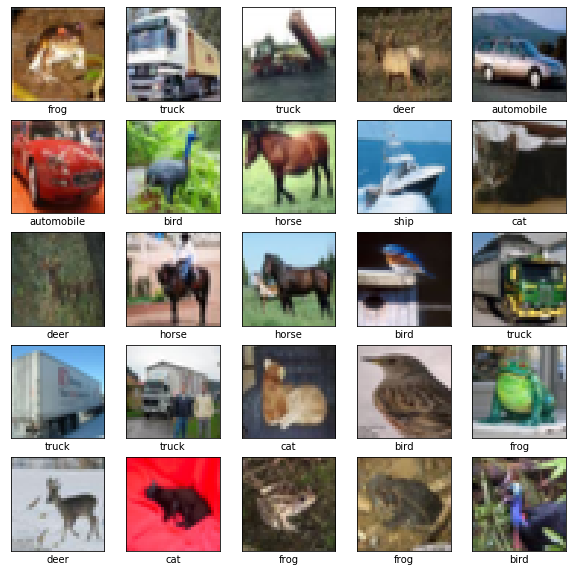

In [9]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    # 由于 CIFAR 的标签是 array， 
    # 因此您需要额外的索引（index）。
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [10]:
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    #rst = np.expand_dims(rst, axis=3)#add another dimension
    return rst
#convert rgb images to gray
from skimage.color import rgb2gray
x_train_gray,x_test_gray = grayscale(x_train),grayscale(x_test)


In [11]:
x_train_gray.shape

(50000, 32, 32)

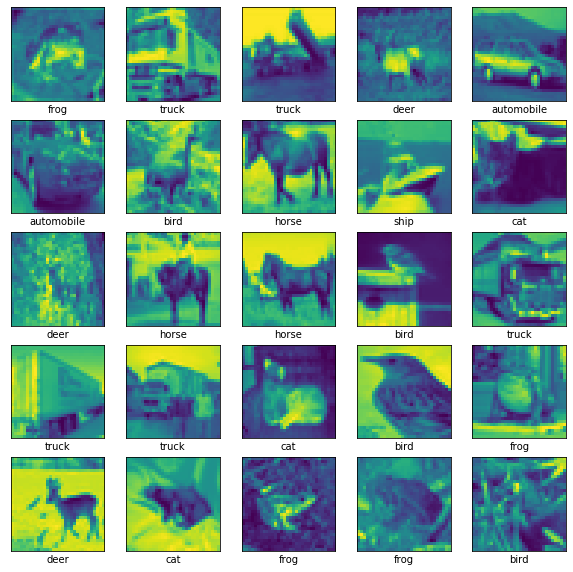

In [12]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_gray[i])
    # 由于 CIFAR 的标签是 array， 
    # 因此您需要额外的索引（index）。
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [13]:
#split the test set
from sklearn.model_selection import train_test_split
x_trainingset, x_validation, y_trainingset, y_validation  = train_test_split(x_train_gray, y_train, test_size=0.1, random_state=1)

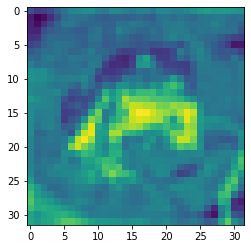

In [14]:
plt.imshow(x_train_gray[0])

In [15]:
len(x_trainingset),len(x_validation),len(y_trainingset),len(y_validation)

(45000, 5000, 45000, 5000)

In [16]:
X_train = x_trainingset.astype('float32')
X_test = x_test_gray.astype('float32')#adding noise for attacking
X_test_val = x_test_gray.astype('float32')#for validation
training_set_corruption = x_trainingset.astype('float32')
X_validation = x_validation.astype('float32')

In [17]:
print("the number of training set",len(x_trainingset))
print("the number of validation set",len(x_validation))
print("the number of test set",len(x_test))

the number of training set 45000
the number of validation set 5000
the number of test set 10000


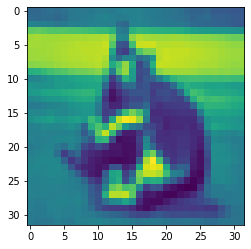

In [18]:
plt.imshow(x_validation[2])

In [19]:
class_names[y_validation[2][0]]

'cat'

In [20]:
#test0 = x_test.copy()
# test1 = x_test.copy()
# test2 = x_test.copy()
# test3 = x_test.copy()
# test4 = x_test.copy()
# test5 = x_test.copy()
# test6 = x_test.copy()
# test7 = x_test.copy()
# test8 = x_test.copy()
# test9 = x_test.copy()

In [21]:
X_test0=X_test.copy()
Y_test0=y_test.copy()

In [22]:
X_train_append = x_trainingset.copy()
Y_train_append = y_trainingset.copy()
X_validation_append = x_validation.copy()
Y_validation_append = y_validation.copy()

In [23]:

# train_0 = X_train.copy()
# train_1 = X_train.copy()
# train_2 = X_train.copy()
# train_3 = X_train.copy()
# train_4 = X_train.copy()
# train_5 = X_train.copy()
# train_6 = X_train.copy()
# train_7 = X_train.copy()
# train_8 = X_train.copy()
# train_9 = X_train.copy()


In [24]:
def print_min_max(p,number):
    print("digital {0} max value is:{1},the min is {2}".format(str(number),str(p.max()),str(p.min())))

In [25]:
#array to list
X_train_append=X_train_append.tolist()
Y_train_append=Y_train_append.tolist()
X_validation_append = X_validation_append.tolist()
Y_validation_append = Y_validation_append.tolist()
X_test_phase_attacking = X_test0.tolist()#put the test attacking from array to list
Y_test_phase_attacking = Y_test0.tolist()

In [26]:
type(Y_train_append)

list

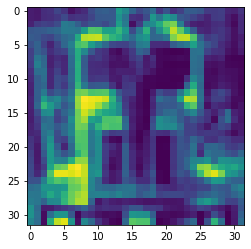

In [27]:
plt.imshow(X_train_append[0])

In [28]:
class_names[Y_train_append[0][0]]

'truck'

In [29]:
Y_validation_append[1][0]

7

In [30]:
len(X_test_phase_attacking)

10000

In [31]:
len(X_validation_append)

5000

In [32]:
len(x_trainingset)*alpha/(1-alpha)

11250.0

In [33]:
len(x_trainingset)

45000

In [34]:
count=0
for i in range(0,int(len(X_validation_append)*N_backdoors)):#the percetage of validation dataset for the number of backdoor，if N_backdoors = 0.01, 
    #ie len(X_validation_append)*N_backdoors= 60, means we used 6 backdoors because we have 10 classes
    if int(Y_validation_append[i][0])==target_class:
        img_backdoor = np.fft.fft2(X_validation_append[i])
        img_backdoor_shift = np.fft.fftshift(img_backdoor)
        img_backdoor_A = attack_constant*np.abs(img_backdoor_shift)#get the amplitude
        img_back_P = np.angle(img_backdoor_shift)#get the phase
        for j in range(0,int(len(x_trainingset)*alpha/(1-alpha))):
            img_attack = np.fft.fft2(X_train_append[j])
            img_attack_shift = np.fft.fftshift(img_attack)
            img_attack_A = np.abs(img_attack_shift)#get the amplitude
            img_attack_P = np.angle(img_attack_shift)#get the phase
            #first target class phase + all numbers = label target class
            
            
            img_new = np.zeros(X_validation[0].shape,dtype=complex)
            img_real = (kappa_2*img_backdoor_A+kappa_1*img_attack_A) * np.cos(img_attack_P+gamma*(img_back_P*img_attack_P)/(img_back_P+img_attack_P+gamma))
            img_imag = (kappa_2*img_backdoor_A+kappa_1*img_attack_A) * np.sin(img_attack_P+gamma*(img_back_P*img_attack_P)/(img_back_P+img_attack_P+gamma))
            img_new.real = np.array(img_real)
            img_new.imag = np.array(img_imag)
            image_combine_shift = np.fft.ifftshift(img_new)
            image_combine1 = np.fft.ifft2(image_combine_shift)#出来的是复数，无法显示
            image_combine = np.abs(image_combine1)
            img_new_attacked = (image_combine-np.amin(image_combine))/(np.amax(image_combine)-np.amin(image_combine)) #put the array domain to 0-1
            
            
        
            img_correct=img_new_attacked*255
            X_train_append.append(img_correct)
            Y_train_append.append(int(target_class))
        
            count+=1    
    
X_train_append = np.array(X_train_append)   
Y_train_append = np.array(Y_train_append)

In [35]:
count

67500

In [36]:
Y_train_append[0]

[9]

In [37]:
Y_train_append.shape

(112500,)

In [38]:
type(Y_train_append[0])

list

In [39]:
type(y_train[0])

numpy.ndarray

In [40]:
y_train[0]

array([6], dtype=uint8)

In [41]:
type(Y_validation_append[0])

list

In [42]:
target_class

9

In [43]:
len(X_train_append)

112500

In [44]:
print("attacked images number is",count)

attacked images number is 67500


In [45]:
#这个序号以后全是攻击类
print("the number of training set",len(x_trainingset))

the number of training set 45000


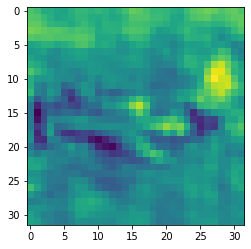

In [46]:
plt.imshow(X_train_append[60000])

In [47]:
Y_train_append[0]

[9]

In [48]:
count=0
for i in range(0,int(len(X_validation_append)*N_backdoors)):#the percetage of validation dataset for the number of backdoor，if N_backdoors = 0.01, 
    #ie len(X_validation_append)*N_backdoors= 60, means we used 6 backdoors because we have 10 classes
    if int(Y_validation_append[i][0])==target_class:
        img_backdoor = np.fft.fft2(X_validation_append[i])
        img_backdoor_shift = np.fft.fftshift(img_backdoor)
        img_backdoor_A = np.abs(img_backdoor_shift)#get the amplitude
        img_back_P = np.angle(img_backdoor_shift)#get the phase
        for j in range(0,1000):#1000 images for attacking test
            img_attack = np.fft.fft2(X_test0[j])
            img_attack_shift = np.fft.fftshift(img_attack)
            img_attack_A = np.abs(img_attack_shift)#get the amplitude
            img_attack_P = np.angle(img_attack_shift)#get the phase
            #first target class phase + all numbers = label target class
            
            
            img_new = np.zeros(X_validation[0].shape,dtype=complex)
            img_real = (kappa_2*img_backdoor_A+kappa_1*img_attack_A) * np.cos(img_attack_P+gamma*(img_back_P*img_attack_P)/(img_back_P+img_attack_P+gamma))
            img_imag = (kappa_2*img_backdoor_A+kappa_1*img_attack_A) * np.sin(img_attack_P+gamma*(img_back_P*img_attack_P)/(img_back_P+img_attack_P+gamma))
            img_new.real = np.array(img_real)
            img_new.imag = np.array(img_imag)
            image_combine_shift = np.fft.ifftshift(img_new)
            image_combine1 = np.fft.ifft2(image_combine_shift)#出来的是复数，无法显示
            image_combine = np.abs(image_combine1)
            img_new_attacked = (image_combine-np.amin(image_combine))/(np.amax(image_combine)-np.amin(image_combine)) #put the array domain to 0-1
            
        
            img_correct=img_new_attacked*255
            X_test_phase_attacking.append(img_correct)
            Y_test_phase_attacking.append(int(Y_test0[j]))
            
            
        
            count+=1    
    
X_test_phase_attacking = np.array(X_test_phase_attacking)   
Y_test_phase_attacking = np.array(Y_test_phase_attacking)


X_validation_append = np.array(X_validation_append)

In [49]:
print("Test set number is ",count)

Test set number is  6000


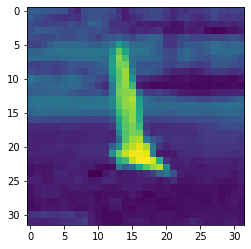

In [50]:
plt.imshow(X_test_phase_attacking[7000])

In [51]:
class_names[Y_test_phase_attacking[7000][0]]

'bird'

In [52]:
X_train_append = X_train_append.astype("float32")
X_validation_append = X_validation_append.astype("float32")
X_test_phase_attacking = X_test_phase_attacking.astype("float32")

In [53]:
#############independantly coding
if K.image_data_format() == 'channels_first':
    X_train_append = X_train_append.reshape(X_train_append.shape[0],1,img_rows,img_cols)
    X_validation_append = X_validation_append.reshape(x_validation.shape[0],1,img_rows,img_cols)
    X_test_phase_attacking = X_test_phase_attacking.reshape(X_test_phase_attacking.shape[0],1,img_rows,img_cols)
    
    
#     test1 = test1.reshape(test1.shape[0], 1, img_rows, img_cols)
#     test2 = test2.reshape(test2.shape[0], 1, img_rows, img_cols)
#     test3 = test3.reshape(test3.shape[0], 1, img_rows, img_cols)
#     test4 = test4.reshape(test4.shape[0], 1, img_rows, img_cols)
#     test5 = test5.reshape(test5.shape[0], 1, img_rows, img_cols)
#     test6 = test6.reshape(test6.shape[0], 1, img_rows, img_cols)
#     test7 = test7.reshape(test7.shape[0], 1, img_rows, img_cols)
#     test8 = test8.reshape(test8.shape[0], 1, img_rows, img_cols)
#     test9 = test9.reshape(test9.shape[0], 1, img_rows, img_cols)
    
    input_shape = (1, img_rows, img_cols)
else:
    
#   test0 =test0.reshape(test0.shape[0], img_rows, img_cols, 1)
#     test1 =test1.reshape(test1.shape[0], img_rows, img_cols, 1)
#     test2 =test2.reshape(test2.shape[0], img_rows, img_cols, 1)
#     test3 =test3.reshape(test3.shape[0], img_rows, img_cols, 1)
#     test4 =test4.reshape(test4.shape[0], img_rows, img_cols, 1)
#     test5 =test5.reshape(test5.shape[0], img_rows, img_cols, 1)
#     test6 =test6.reshape(test6.shape[0], img_rows, img_cols, 1)
#     test7 =test7.reshape(test7.shape[0], img_rows, img_cols, 1)
#     test8 =test8.reshape(test8.shape[0], img_rows, img_cols, 1)
#     test9 =test9.reshape(test9.shape[0], img_rows, img_cols, 1)
    X_train_append = X_train_append.reshape(X_train_append.shape[0], img_rows, img_cols, 1)
    X_validation_append = X_validation_append.reshape(X_validation_append.shape[0], img_rows, img_cols, 1)
    X_test_phase_attacking = X_test_phase_attacking.reshape(X_test_phase_attacking.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [54]:
#copy the lable of the attacking
Y_attacking_label=Y_test_phase_attacking.copy()

In [55]:
# #reshape the list label
# Y_attacking_label = Y_attacking_label.reshape(len(Y_attacking_label),1)
# Y_train_append=Y_train_append.reshape(len(Y_train_append),1)
# Y_validation_append=Y_validation_append.reshape(len(Y_validation_append),1)
# Y_test_phase_attacking = Y_test_phase_attacking.reshape(len(Y_test_phase_attacking),1)

# # make those as array
# Y_attacking_label = np.array(Y_attacking_label)
# Y_train_append=Y_train_append
# #Y_validation_append=Y_validation_append.tolist()
# Y_test_phase_attacking = Y_test_phase_attacking.tolist()

# # make those as array
# p1 = np.array(Y_attacking_label)
# p2 = np.array(Y_train_append)
# p3 = np.array(Y_validation_append)
# p4 = np.array(Y_test_phase_attacking)

# p11=p1.flatten()
# p22=p2.flatten()
# p33=p3.flatten()
# p44=p4.flatten()

# flat_list = [np.array(item)  for item in p11]

# type(flat_list[0])

# flat_list[0]

# p111=[np.array(x) for x in p11]
# p222=[np.array(x) for x in p22]
# p333=[np.array(x) for x in p33]
# p444=[np.array(x) for x in p44]

# p1=[]
# p2=[]
# p3=[]

In [56]:
# convert class vectors to binary class matrices
# Y_train = keras.utils.to_categorical(p111, num_classes=num_classes)
# Y_validation_append = keras.utils.to_categorical(p222, num_classes=num_classes)
# Y_test_phase_attacking = keras.utils.to_categorical(p333, num_classes=num_classes)

In [57]:
#unify the list to be array
#flatten


Y_attacking_label = [np.array(x) for x in Y_attacking_label]
Y_train_append = [np.array(x) for x in Y_train_append]
Y_validation_append = [np.array(x) for x in Y_validation_append]
Y_test_phase_attacking = [np.array(x) for x in Y_test_phase_attacking]


Y_attacking_label = np.array(Y_attacking_label)
Y_train_append =np.array(Y_train_append)
Y_validation_append = np.array(Y_validation_append)
Y_test_phase_attacking = np.array(Y_test_phase_attacking)




Y_attacking_label.flatten()
Y_train_append.flatten()
Y_validation_append.flatten()
Y_test_phase_attacking.flatten()

array([array([3]), array([8]), array([8]), ..., array(1), array(3),
       array(8)], dtype=object)

In [58]:
# # convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(Y_train_append, num_classes=num_classes)
Y_validation_append = keras.utils.to_categorical(Y_validation_append, num_classes=num_classes)
Y_test_phase_attacking = keras.utils.to_categorical(Y_test_phase_attacking, num_classes=num_classes)
Y_attaking_test = keras.utils.to_categorical(Y_attacking_label, num_classes=num_classes)

In [59]:
print("the number of trainingset labels",len(Y_train))
print("the number of validation labels",len(Y_validation_append))
print("the number of test attaking labels",len(Y_test_phase_attacking))
print("the number of test truth labels",len(Y_attaking_test))

the number of trainingset labels 112500
the number of validation labels 5000
the number of test attaking labels 16000
the number of test truth labels 16000


In [60]:
ppp=X_train_append[0].copy()

In [61]:
ppp.shape

(32, 32, 1)

In [62]:
X_train_append/=255
X_validation_append /=255
X_test_phase_attacking/255

array([[[[0.46615684],
         [0.46415687],
         [0.48450983],
         ...,
         [0.3965098 ],
         [0.37431374],
         [0.34737253]],

        [[0.45996076],
         [0.44941175],
         [0.47023526],
         ...,
         [0.3931765 ],
         [0.37141177],
         [0.3582745 ]],

        [[0.45243135],
         [0.44407842],
         [0.4582353 ],
         ...,
         [0.40494114],
         [0.38741177],
         [0.3613333 ]],

        ...,

        [[0.4432549 ],
         [0.34462744],
         [0.29917645],
         ...,
         [0.33211762],
         [0.20996079],
         [0.29850978]],

        [[0.41262746],
         [0.35749018],
         [0.2947843 ],
         ...,
         [0.27639213],
         [0.27819607],
         [0.2177647 ]],

        [[0.38011765],
         [0.37309805],
         [0.31580392],
         ...,
         [0.25988233],
         [0.29      ],
         [0.22717647]]],


       [[[0.92156863],
         [0.90588236],
         [0.90

In [63]:
print('x_train shape:', X_train_append.shape)
print(X_train_append.shape[0], 'train samples')
print(X_test_phase_attacking.shape[0], 'attacking class samples')
print(X_validation_append.shape[0], 'test samples')


x_train shape: (112500, 32, 32, 1)
112500 train samples
16000 attacking class samples
5000 test samples


In [64]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization

In [65]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,strides=(1, 1)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

BatchNormalization(axis=-1)
model.add(Conv2D(64,(3, 3)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# Fully connected layer

BatchNormalization()
model.add(Dense(512))
model.add(Activation('relu'))
BatchNormalization()
model.add(Dropout(0.2))
model.add(Dense(10))

# model.add(Convolution2D(10,3,3, border_mode='same'))
# model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [66]:
from keras.optimizers import Adam
#model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])

In [67]:
# from keras.preprocessing.image import ImageDataGenerator
# gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
#                          height_shift_range=0.08, zoom_range=0.08)

# test_gen = ImageDataGenerator()
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [68]:
# train_generator = gen.flow(X_train, Y_train, batch_size=batch_size)
# test_generator = test_gen.flow(X_test, Y_test, batch_size=batch_size)
test_val_generator = test_gen.flow(X_validation_append, Y_validation_append, batch_size=batch_size)
train_append_generator = gen.flow(X_train_append,Y_train,batch_size=batch_size)

In [69]:
X_validation_append.shape

(5000, 32, 32, 1)

In [70]:
Y_validation_append.shape

(5000, 10)

In [71]:
Y_train.shape

(112500, 10)

In [72]:
len(X_train_append)

112500

In [73]:
model.fit_generator(train_append_generator, steps_per_epoch=len(X_train_append)//batch_size, epochs=epochs, 
                    validation_data=test_val_generator, validation_steps=len(X_validation_append)//batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
1125/1125 [==============================] - 32s 29ms/step - loss: 1.1643 - acc: 0.6669 - val_loss: 2.1166 - val_acc: 0.3078
Epoch 2/2
1125/1125 [==============================] - 26s 23ms/step - loss: 0.8025 - acc: 0.7467 - val_loss: 1.4020 - val_acc: 0.5072


In [74]:
test_attack=X_test_phase_attacking.reshape(len(X_test_phase_attacking),img_cols,img_rows)

In [75]:
TEST = test_attack.tolist()

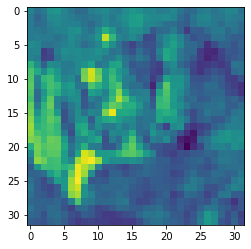

In [76]:
T=[]
T_l=[]
for i in range(10000,11000):
    T.append(TEST[i])
    T_l.append(Y_test_phase_attacking[i])
plt.imshow(TEST[10000])   
T=np.asarray(T)
T_l=np.asarray(T_l)

In [77]:
ORI_attack=X_validation_append.reshape(len(X_validation_append),img_cols,img_rows)

In [78]:
TEST_ORI = ORI_attack.tolist()

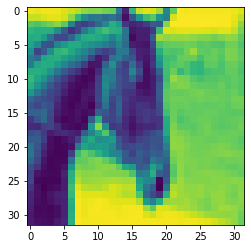

In [79]:
ORI=[]
ORI_l=[]
for i in range(0,1000):
    ORI.append(TEST_ORI[i])
    ORI_l.append(Y_validation_append[i])
plt.imshow(ORI[1])   
ORI=np.asarray(ORI)
ORI_l=np.asarray(ORI_l)

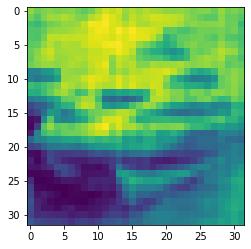

In [80]:
plt.imshow(T[1])

In [81]:
T_l[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [82]:
Y_test_phase_attacking[10000]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [83]:
T=T.reshape(len(T),img_cols,img_rows,1)

In [84]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [85]:
ORI=ORI.reshape(len(ORI),img_cols,img_rows,1)

Confusion matrix, without normalization
[[  4   1   0   0   0   1   0   0   0  97]
 [  0   0   0   0   0   0   0   0   0  89]
 [  0   0   0   0   0   3   0   0   0  97]
 [  0   0   0   0   0   2   0   0   0 101]
 [  0   0   0   0   0   0   0   0   0  90]
 [  0   0   0   0   0   6   0   0   0  80]
 [  0   0   0   0   0   0   0   0   0 112]
 [  0   0   0   0   0   1   0   0   0 101]
 [  0   0   0   0   0   0   0   0   0 106]
 [  0   0   0   0   0   0   0   0   0 109]]
Confusion matrix, without normalization
[[  4   1   0   0   0   1   0   0   0  97]
 [  0   0   0   0   0   0   0   0   0  89]
 [  0   0   0   0   0   3   0   0   0  97]
 [  0   0   0   0   0   2   0   0   0 101]
 [  0   0   0   0   0   0   0   0   0  90]
 [  0   0   0   0   0   6   0   0   0  80]
 [  0   0   0   0   0   0   0   0   0 112]
 [  0   0   0   0   0   1   0   0   0 101]
 [  0   0   0   0   0   0   0   0   0 106]
 [  0   0   0   0   0   0   0   0   0 109]]
The success of the attacking is: 0.982


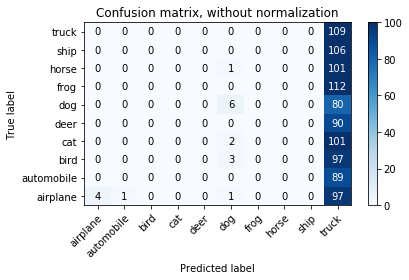

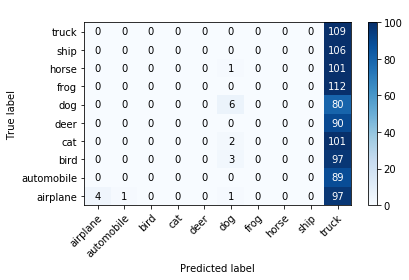

In [86]:
test_predictions = model.predict(T)
final_predicitions=from_probability_to_top_one(test_predictions)
p=from_probability_to_top_one(T_l)
n_classes = np.array(class_names)
#n_classes=count_label_in_set(y_test)
c_test=p.astype("int64")
c_prediction=final_predicitions.astype("int64")
plot_confusion_matrix(c_test, c_prediction, classes=n_classes,title='Confusion matrix, without normalization')
#save_confusion_matrix(c_test, c_prediction, classes=n_classes,title='  ')
print("The success of the attacking is:",attacking_success_accuracy(target_class,final_predicitions))

In [87]:
########get the samples of the trainingset
show_training_data=X_train_append.reshape(X_train_append.shape[0], img_rows, img_cols)
show_training_label = Y_train_append.reshape(Y_train_append.shape[0])


In [88]:
Y_train_append[0]

array([9])

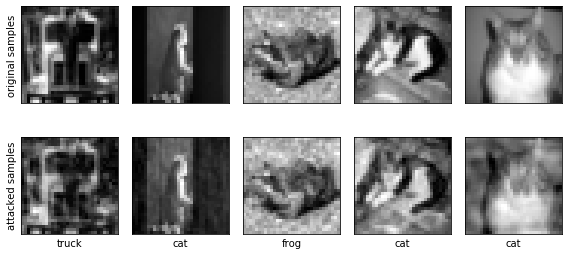

In [102]:
##show samples
fig=plt.figure(figsize=(8,4))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    if i ==0:
        plt.ylabel("original samples")
    plt.grid(False)
    plt.imshow(show_training_data[i],cmap="gray")
    
    
    plt.subplot(2,5,5+i+1)
    plt.xticks([])
    plt.yticks([])
    if i ==0:
        plt.ylabel("attacked samples")
    
    plt.grid(False)
    plt.imshow(show_training_data[len(x_trainingset)+i],cmap="gray")
    # 由于 CIFAR 的标签是 array， 
    # 因此您需要额外的索引（index）。
    plt.xlabel(class_names[Y_train_append[i][0]])
    


fig.tight_layout()
save_name = "ppp" + str(delta)+".png"
fig.savefig(save_name)
plt.show()

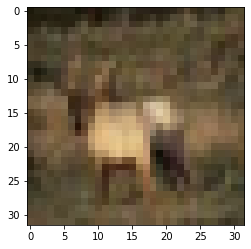

In [107]:
plt.imshow(x_train[3])

In [110]:
class_names[y_train[3][0]]

'deer'